# EMRI Waveforms in frequency domain
We present the usage of the EMRI Waveforms in Frequency domain and compare the spectrum to the time domain implementation.

In [80]:
import sys, time, h5py,os
import matplotlib
import scienceplots
import numpy as np
import matplotlib.pyplot as plt

# import or install these packages for the data anlysis of the resultss
sys.path.append("../LISAanalysistools/")
sys.path.append("../Eryn/")

import corner
from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")
omp_set_num_threads(1)
from few.utils.utility import cuda_set_device

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from FDutils import *

try:
    import cupy as xp
    # set GPU device
    os.system(f"CUDA_VISIBLE_DEVICES=0")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")


few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)


import matplotlib as mpl

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean


# fontsize label
fs_lab = 18
# legend
fs_leg = 14
# ticks
fs_ticks = 14
mpl.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "figure.figsize": [default_width, default_width * default_ratio],
  'legend.fontsize': fs_leg,
  'xtick.labelsize': fs_ticks,
  'ytick.labelsize': fs_ticks,
})

In [81]:
# define the injection parameters
M = 1e6 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 10.0 # secondary object mass
p0 = 12.0 # initial semi-latus rectum
e0 = 0.6 # eccentricity

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 1.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
traj_module,
Tobs*0.99,
[M, mu, 0.0, e0, 1.0],
index_of_p=3,
index_of_a=2,
index_of_e=4,
index_of_x=5,
traj_kwargs={},
xtol=2e-12,
rtol=8.881784197001252e-16,
bounds=None,
)


emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]

## Comparison against the Time Domain Waveforms

In [82]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# take the FFT of the plus polarization and shift it
fft_TD = xp.fft.fftshift(xp.fft.fft(data_channels_td[0])) * dt
freq = xp.fft.fftshift(xp.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


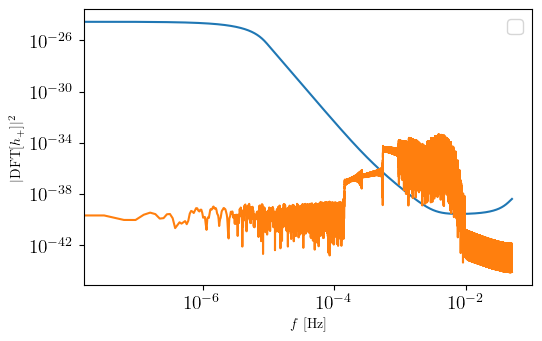

In [83]:
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()))
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2)
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]))
plt.ylabel(r'$| {\rm DFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [84]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq
fd_kwargs['mask_positive']=True

# get FD waveform
hf = few_gen(*emri_injection_params,**fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 0.0008525435676286497


In [85]:
# 220 mode
fd_kwargs2 = fd_kwargs.copy()
del fd_kwargs2['eps']
fd_kwargs2['mode_selection'] = [(2,2,0)]
hf_220 = few_gen(*emri_injection_params,**fd_kwargs2)
# sig_fd_windowed = [el[positive_frequency_mask] for el in get_fd_windowed(hf_toconv, window)]

Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf_220[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 0.9309246298293741


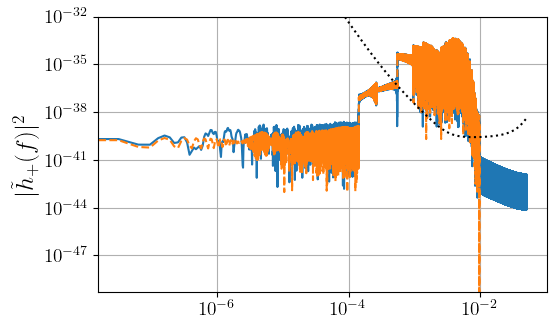

In [86]:
# FD plot
enlarge = 1.1
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2,label='DFT of TD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,'--',label='FD waveform')
#     plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf_220[0].get())**2 ,'-.',label='FD waveform (l,m,n)=(2,2,0)',)
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()),'k:',label='LISA sensitivity')

else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='DFT of TD waveform')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
#     plt.loglog(freq[positive_frequency_mask], np.abs(hf_220[0])**2 ,'-.',label='FD waveform (l,m,n)=(2,2,0)',)
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+} (f)|^2$',fontsize=fs_lab)
plt.grid()
# plt.xlabel(r'$f$ [Hz]')
# plt.legend()
plt.ylim([0.5e-49, 1e-32])

plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

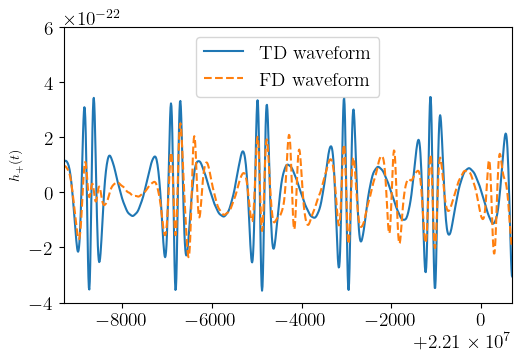

In [87]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],hf[0][::-1][:-1] )/dt)
ifft_fd_22 = xp.fft.ifft(xp.append(hf_220[0],xp.flip(hf_220[0][1:] ))/dt)


enlarge = 1.1
plt.figure()


if use_gpu:
    plt.plot(time_array, data_channels_td[0].get(),label='TD waveform')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='FD waveform')
#     plt.plot(time_array, ifft_fd_22.get(),'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')

else:
    plt.plot(time_array, data_channels_td[0],label='TD waveform')
    plt.plot(time_array, ifft_fd,'--' ,label='Inverse DFT FD waveform')
#     plt.plot(time_array, ifft_fd_22,'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')
plt.ylabel(r'$h_{+}(t)$')
# plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')

plt.savefig('figures/FD_TD_time.pdf', bbox_inches='tight')

## Windowing

In [88]:
window = None # xp.asarray(hann(len(data_channels_td[0])))
fft_td_gen = get_fd_waveform_fromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = get_fd_waveform_fromFD(few_gen, positive_frequency_mask, dt, window=window)
fd_kwargs_nomask = fd_kwargs.copy()
del fd_kwargs_nomask['mask_positive']
xp.all(fd_gen(*emri_injection_params,**fd_kwargs_nomask)[0]==hf[0])
# add windowing
window = xp.asarray(hann(len(data_channels_td[0])))#xp.asarray(data_channels_td[0]==0.0,dtype=float)#
fft_td_gen = get_fd_waveform_fromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = get_fd_waveform_fromFD(few_gen, positive_frequency_mask, dt, window=window)

hf = fd_gen(*emri_injection_params,**fd_kwargs_nomask)
fft_TD = fft_td_gen(*emri_injection_params,**fd_kwargs_nomask)

fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[0], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 3.90478364942215e-06


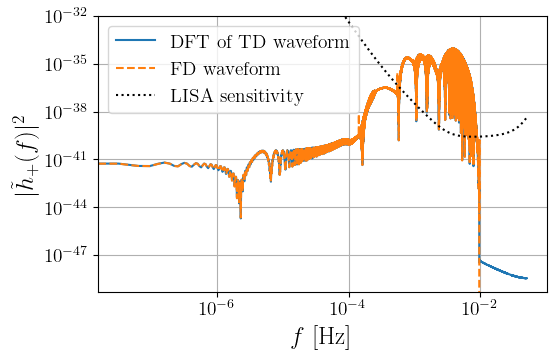

In [89]:
# FD plot
enlarge = 1.1
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[0].get())**2,label='DFT of TD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,'--',label='FD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()),'k:',label='LISA sensitivity')

else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[0])**2,label='DFT of TD waveform')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+}(f)|^2$',fontsize=fs_lab)
plt.xlabel(r'$f$ [Hz]',fontsize=fs_lab)
plt.legend(loc='upper left')
plt.grid()
plt.ylim([0.5e-49, 1e-32])
plt.savefig('figures/FD_TD_frequency_windowed.pdf', bbox_inches='tight')

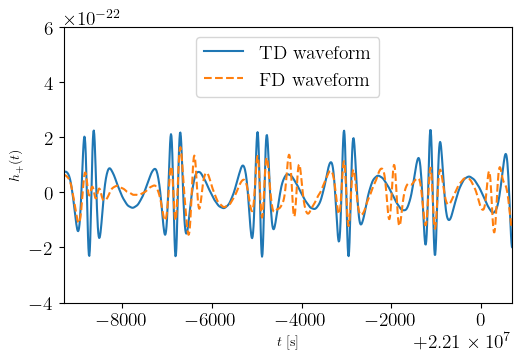

In [90]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],hf[0][::-1][:-1] )/dt)


enlarge = 1.1
plt.figure()


if use_gpu:
    plt.plot(time_array, data_channels_td[0].get()*window.get(),label='TD waveform')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='FD waveform')

else:
    plt.plot(time_array, data_channels_td[0]*window,label='TD waveform')
    plt.plot(time_array, ifft_fd,'--' ,label='FD waveform')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')

plt.savefig('figures/FD_TD_time_windowed.pdf', bbox_inches='tight')

## Mass invariance
Simple check to test the mass invariance in FD.

In [91]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
Mvec = 10**np.linspace(5.0,6.5,num=3)

for M in Mvec:

    # fix mass ratio
    mu = 5e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,
                T=10.0,dt=dt,mode_selection=[(2,2,0)],mask_positive=True)
    )

    # adimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

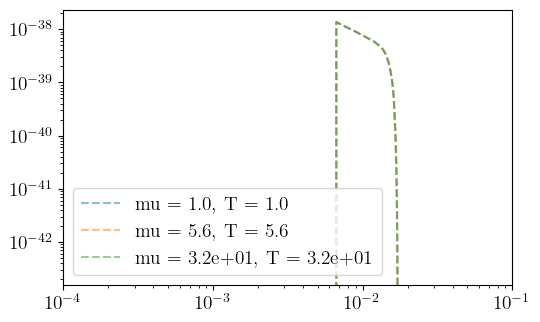

In [92]:
plt.figure()

for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii]
    ff = ff[ff>=0.0]
    h2 = xp.abs(list_h[ii][0] / (tmp_mu * Tnew) )**2 
    if use_gpu:
        plt.loglog(ff.get(), h2.get(),'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)
    else:
        plt.loglog(ff, h2,'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.xlim([1e-4,1e-1])
plt.legend()
plt.show()

# Downsampled waveforms

In [93]:
M,mu,p0,e0 = 3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371 # 1e6, 10.0, 13.709101864726545, 0.5794130830706371 # 

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 4.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
traj_module,
Tobs*0.99,
[M, mu, 0.0, e0, 1.0],
index_of_p=3,
index_of_a=2,
index_of_e=4,
index_of_x=5,
traj_kwargs={},
xtol=2e-12,
rtol=8.881784197001252e-16,
bounds=None,
)


emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]
p0

13.709101864726545

In [94]:
waveform_kwargs

{'T': 4.0, 'dt': 10.0, 'eps': 0.01}

0.00281577002963022
0.00281577002963022


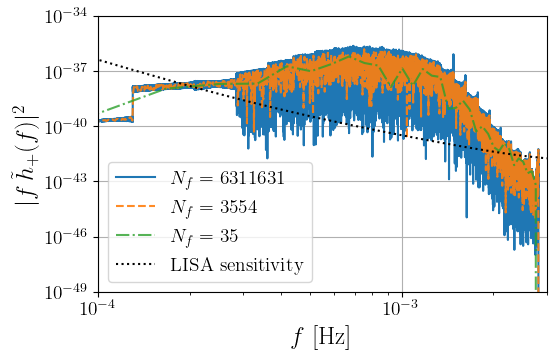

In [95]:
# FD plot
enlarge = 1.1
plt.figure()

num=35
alpha=[1.0,0.9, 0.8, 0.2]
linest = ['-','--','-.',':']
for upp,aa,ls in zip([1, 100,10000],alpha,linest):

    # you can specify the frequencies or obtain them directly from the waveform
    fd_kwargs = waveform_kwargs.copy()
    fd_kwargs['mask_positive']=True
    # get FD waveform
    hf = few_gen(*emri_injection_params,**fd_kwargs)
    freq_fd = few_gen.waveform_generator.create_waveform.frequency
    positive_frequency_mask = (freq_fd>=0.0)
    mask_non_zero = (hf[0]!=complex(0.0))
    end_f = few_gen.waveform_generator.create_waveform.frequency[positive_frequency_mask][mask_non_zero].max()

    if upp!=1:
        num = int( len(freq_fd[positive_frequency_mask][mask_non_zero]) / upp )
        p_freq = np.linspace(0.0, end_f*1.01, num=num ) 
        print(end_f)
        newfreq = xp.hstack((-p_freq[::-1][:-1],
                            p_freq
                            ) )

        # you can specify the frequencies or obtain them directly from the waveform
        fd_kwargs = waveform_kwargs.copy()
        fd_kwargs['f_arr'] = newfreq
        fd_kwargs['mask_positive']=True

        # get FD waveform
        hf = few_gen(*emri_injection_params,**fd_kwargs)
        # to get the frequencies:
        freq_fd = few_gen.waveform_generator.create_waveform.frequency
        positive_frequency_mask = (freq_fd>=0.0)

    Nf = len(freq_fd[positive_frequency_mask])
    plt.loglog(freq_fd[positive_frequency_mask].get(),freq_fd[positive_frequency_mask].get()**2 * np.abs(hf[0].get())**2,ls,label=f'$N_f = $ {Nf}',alpha=aa)


ff = 10**np.linspace(-5,-1,num=100)
plt.loglog(ff, ff*get_sensitivity(ff),'k:',label='LISA sensitivity')

plt.ylabel(r'$|f\, \tilde{h}_{+}(f)|^2$',fontsize=fs_lab)
plt.xlabel(r'$f$ [Hz]',fontsize=fs_lab)
plt.legend(loc='lower left')
plt.xlim(1e-4,3e-3)
plt.grid()
plt.ylim([1e-49, 1e-34])
plt.savefig('figures/spectrum_downsampled.pdf')